In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error

plt.rcParams["figure.figsize"] = (20, 10)


def get_period(data):
    # Assuming 'data' is your np array
    peaks, _ = find_peaks(data)

    # Check for at least 2 peaks to compute a period
    return (peaks[-1] - peaks[0]) / (len(peaks) - 1)


def moving_avg(arr, window_size):
    num_values = len(arr) - window_size + 1

    # Create an empty array to store the moving average values
    avg = np.empty(num_values)

    # Compute the forward moving average
    for i in range(num_values):
        avg[i] = np.mean(arr[i : i + window_size])

    return avg

f(T=500,delta_t=0.04).npy


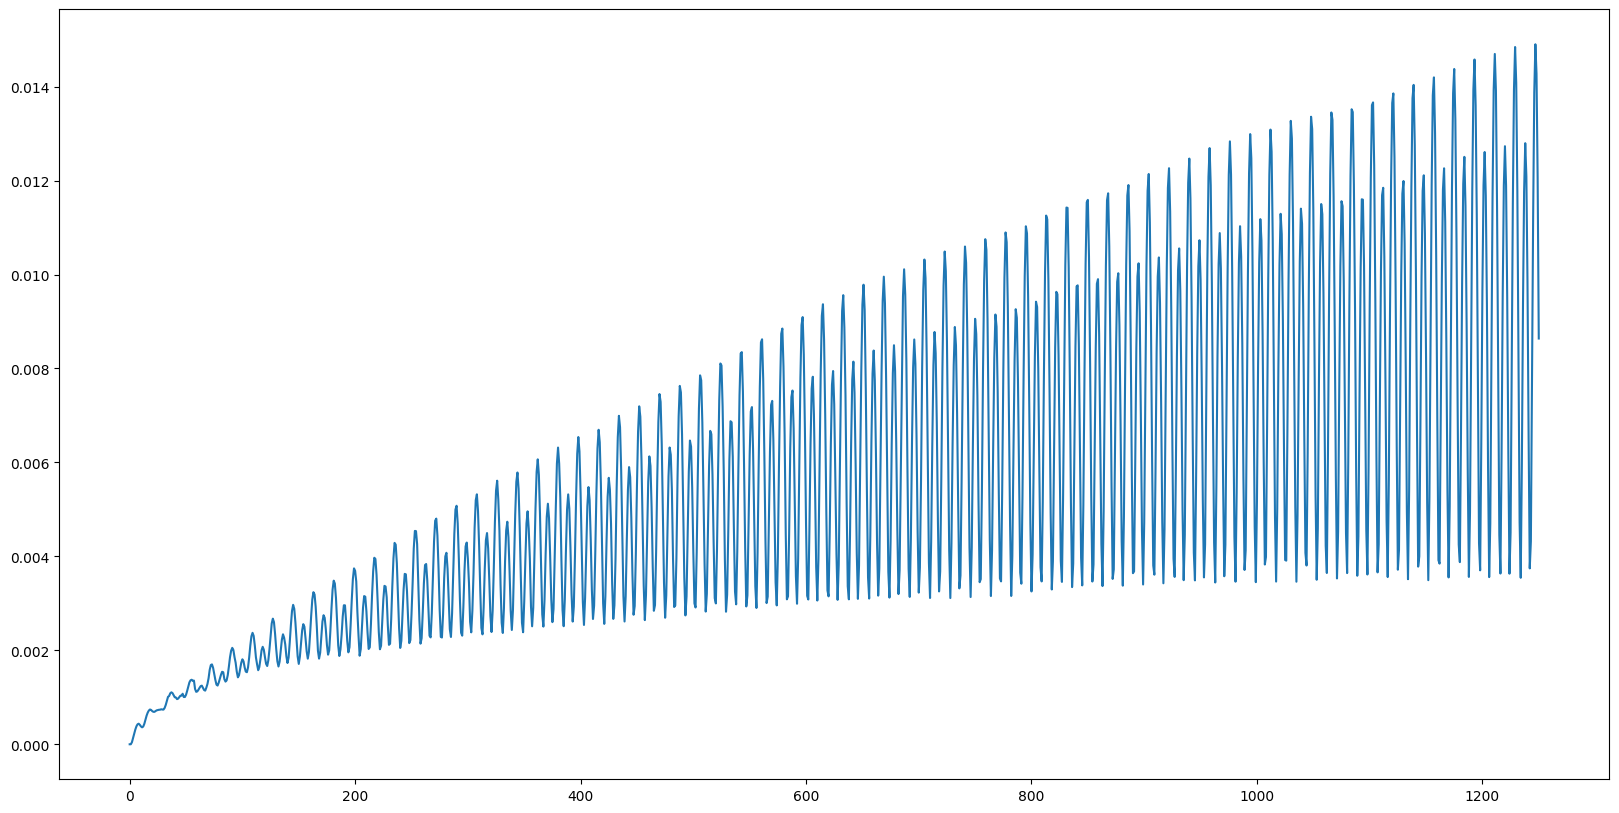

0.3591304347826087
0.04


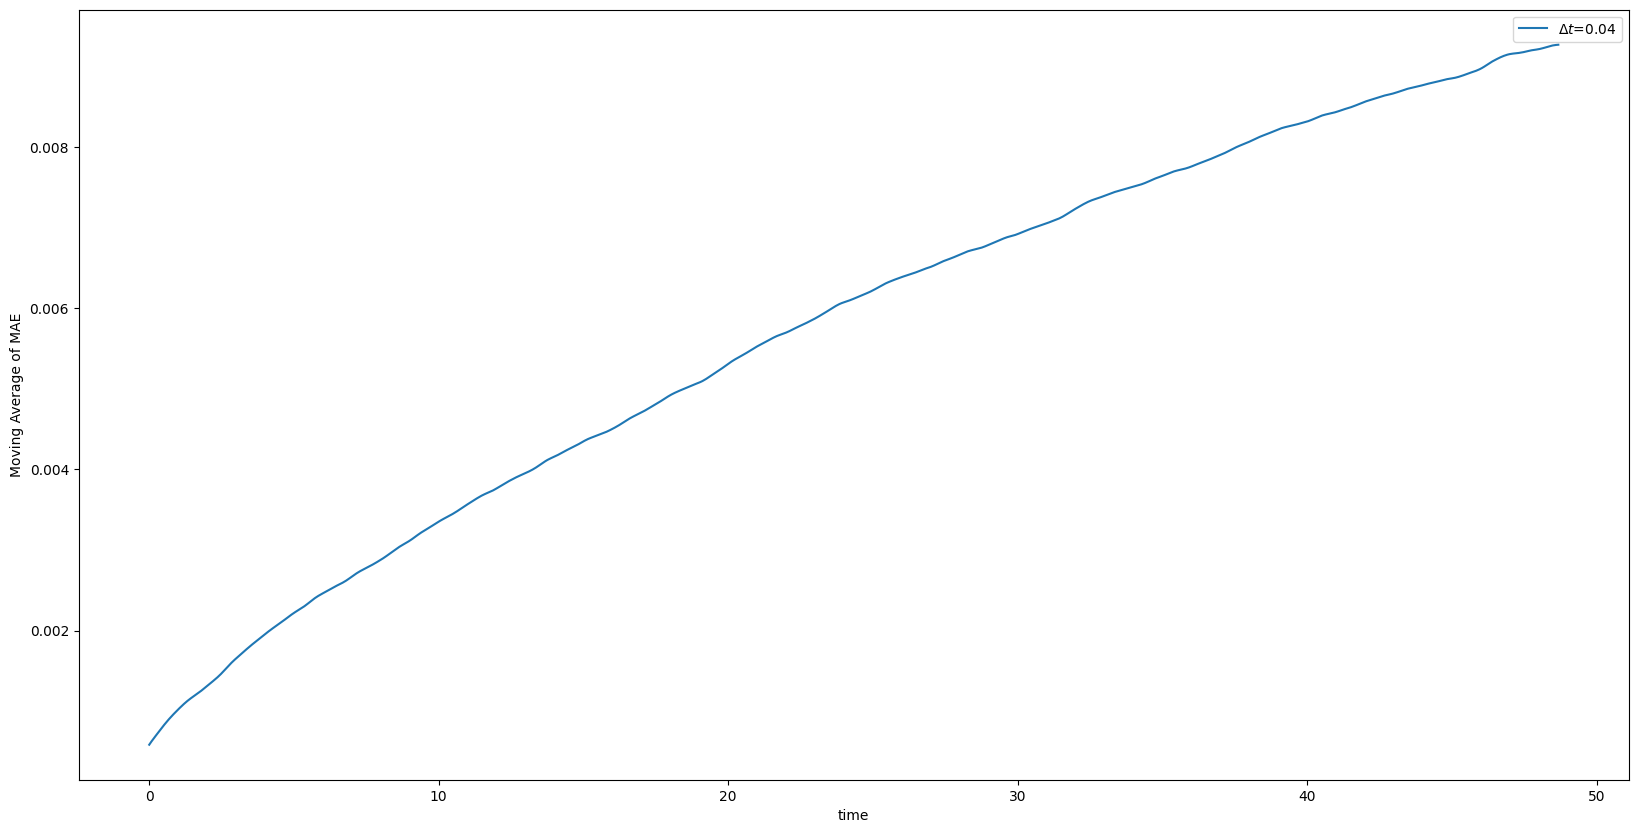

In [8]:
folder_name = ""  # replace 'path_to_the_folder' with the actual path
directory = os.path.join(os.getcwd(), folder_name)
# directory.sort()

t_list = np.arange(0.02, 0.095, 0.01)
t_list = np.flip(t_list)
t_list = [0.04]
index = 0
lgd = []
count = 0

period = 0

x_y = []

# Iterate over all files in the directory
for filename in sorted(os.listdir(directory), reverse=True):
    if filename.endswith(".npy"):
        if "f" in filename:
            print(filename)
            if count >= 10:
                plt.legend(lgd)
                plt.show()
                count = 0
                lgd = []

            delta_t = round(t_list[index], 3)
            arr = np.load(os.path.join(directory, filename))
            plt.plot(arr)
            plt.show()
            # plt.plot(np.arange(0,delta_t*len(arr),delta_t)[:1000],arr[:1000])
            period = get_period(arr) * delta_t
            print(period)
            avg = moving_avg(arr, int(period / delta_t))
            for i in range(2):
                avg = moving_avg(avg, int(get_period(avg)))

            x_val = np.arange(0, delta_t * len(avg), delta_t)
            y_val = avg

            max_len = min(len(x_val), len(y_val))
            plt.plot(x_val[:max_len], y_val[:max_len])
            xy = np.array([x_val[:max_len], y_val[:max_len]])
            print(delta_t)
            np.save(str(delta_t) + ".npy", xy)
            x_y.append((x_val[:max_len], y_val[:max_len]))
            index += 1
            lgd.append(r"$\Delta t$=" + str(delta_t))

plt.xlabel("time")
plt.ylabel("Moving Average of MAE")
plt.legend(lgd)
plt.show()

## Error vs t

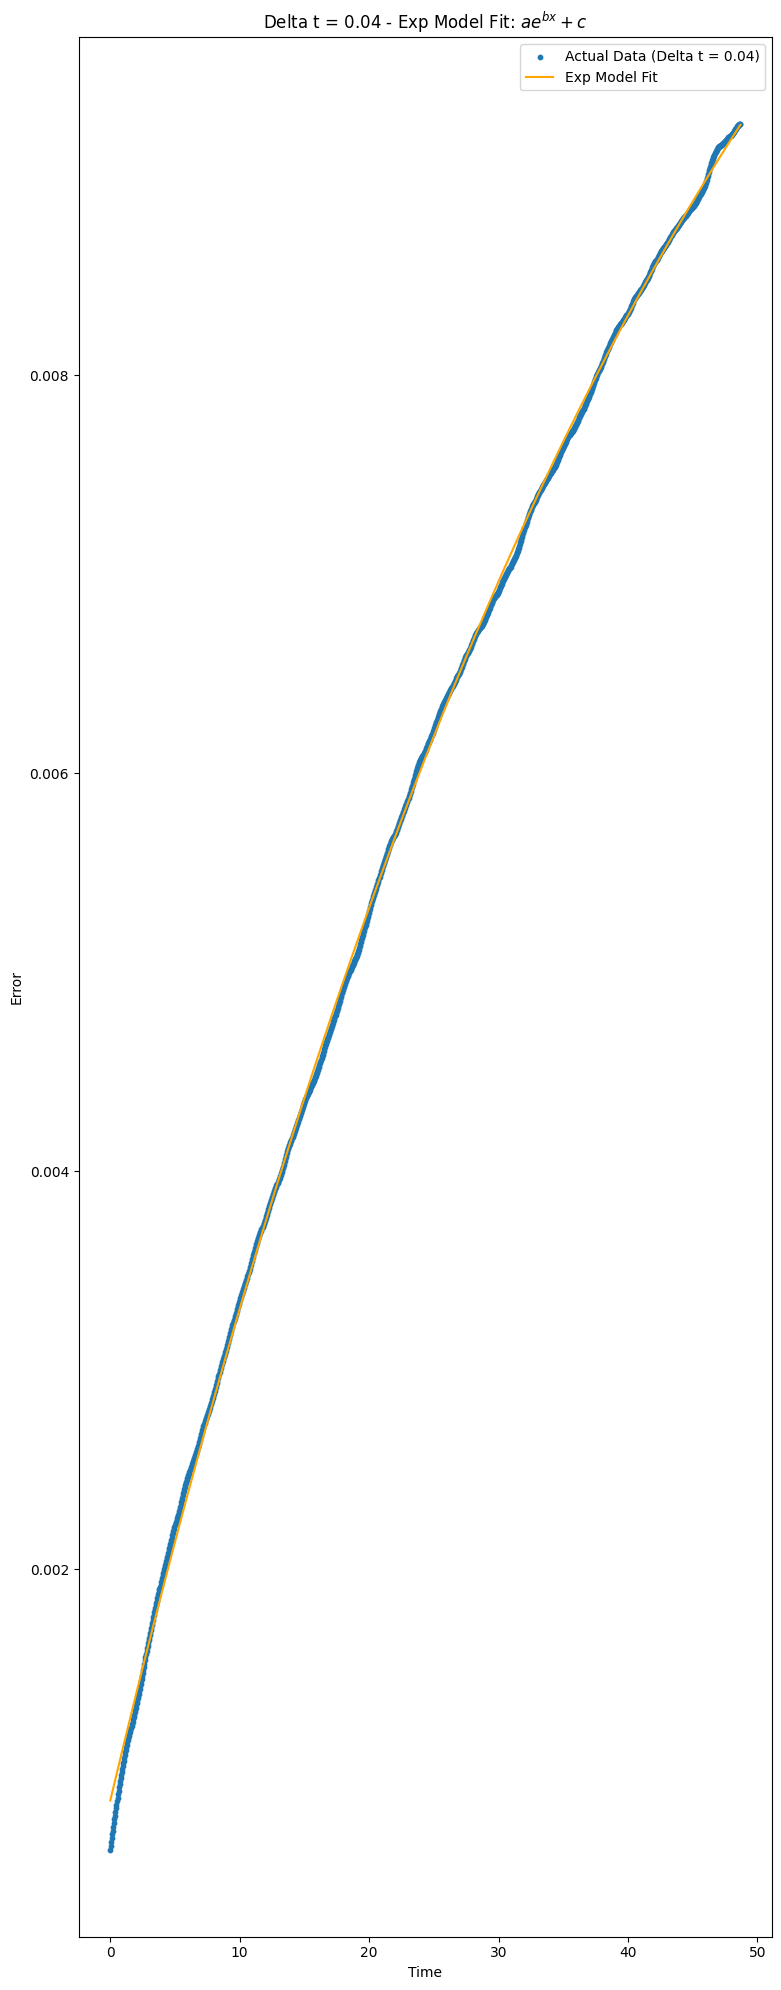

0.04: a=0.013341451147555002, b=0.020498620803045525, c=0.014178271498248773
R2=0.9996570481113327, MSE=1.9989007508076484e-09


<Figure size 2000x1000 with 0 Axes>

In [9]:
# Define the square root model function
def exp_model(x, a, b, c):
    return -a * np.exp(-b * x) + c
    return b * x**a + c
    # return a*x+b
    return a * np.sqrt(x) + b


# List of delta_t values
delta_ts = t_list

# Load the data from .npy files and store in a dictionary with delta_t as keys
data_dict = {}
for delta_t in delta_ts:
    delta_t = round(delta_t, 4)
    file_path = f"{delta_t}.npy"
    data = np.load(file_path, allow_pickle=True)
    data_dict[delta_t] = {"x_coordinates": data[0], "y_coordinates": data[1]}

# Fit the square root model to each dataset and calculate the performance metrics
exp_model_fits = {}
for delta_t, data in data_dict.items():
    # Fit the square root model
    exp_params, _ = curve_fit(exp_model, data["x_coordinates"], data["y_coordinates"])

    # Calculate performance
    y_pred = exp_model(data["x_coordinates"], *exp_params)
    r2 = r2_score(data["y_coordinates"], y_pred)
    mse = mean_squared_error(data["y_coordinates"], y_pred)

    # Store the results
    exp_model_fits[delta_t] = {
        "exp_params": exp_params,
        "performance": {"R2": r2, "MSE": mse},
    }

# Plotting the actual data and the fitted models for each delta_t
plt.figure(figsize=(15, 20))
for i, (delta_t, data) in enumerate(data_dict.items()):
    # Generate a range of x values for plotting the fitted model
    x_range = np.linspace(min(data["x_coordinates"]), max(data["x_coordinates"]), 500)
    # Generate the predicted y values using the fitted square root model
    y_pred = exp_model(x_range, *exp_model_fits[delta_t]["exp_params"])

    # Subplot for each delta_t
    plt.subplot(len(data_dict) // 2 + len(data_dict) % 2, 2, i + 1)
    plt.scatter(
        data["x_coordinates"],
        data["y_coordinates"],
        s=10,
        label=f"Actual Data (Delta t = {delta_t})",
    )
    plt.plot(x_range, y_pred, color="orange", label="Exp Model Fit")
    plt.title(f"Delta t = {delta_t} - Exp Model Fit: " + r"$ae^{bx}+c$")
    plt.xlabel("Time")
    plt.ylabel("Error")
    plt.legend()

plt.tight_layout()
plt.show()
plt.savefig("data_fit.png")

b_inf = {}
for delta_t in exp_model_fits.keys():
    print(
        f'{delta_t}: a={exp_model_fits[delta_t]["exp_params"][0]}, b={exp_model_fits[delta_t]["exp_params"][1]}, c={exp_model_fits[delta_t]["exp_params"][2]}'
    )
    print(
        f'R2={exp_model_fits[delta_t]["performance"]["R2"]}, MSE={exp_model_fits[delta_t]["performance"]["MSE"]}'
    )
    b_inf[delta_t] = -exp_model_fits[delta_t]["exp_params"][1]

## Error vs Δt 

{0.04: -0.020498620803045525}


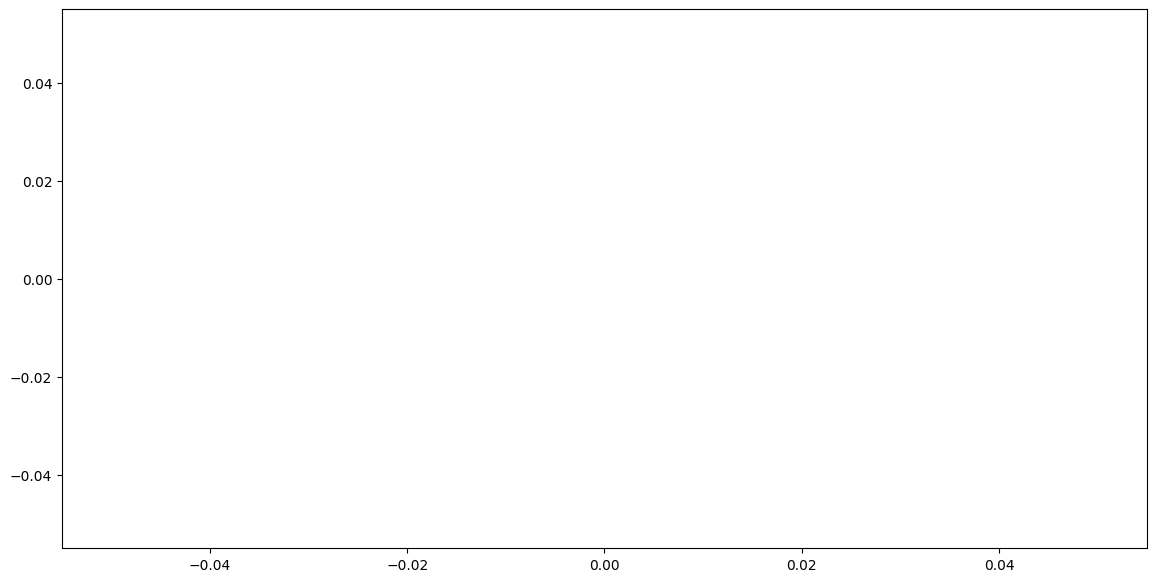

In [10]:
plt.rcParams["figure.figsize"] = (14, 7)
plt.scatter(list(b_inf.keys())[:-1], list(b_inf.values())[:-1])
print(b_inf)

C:\Users\chen9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


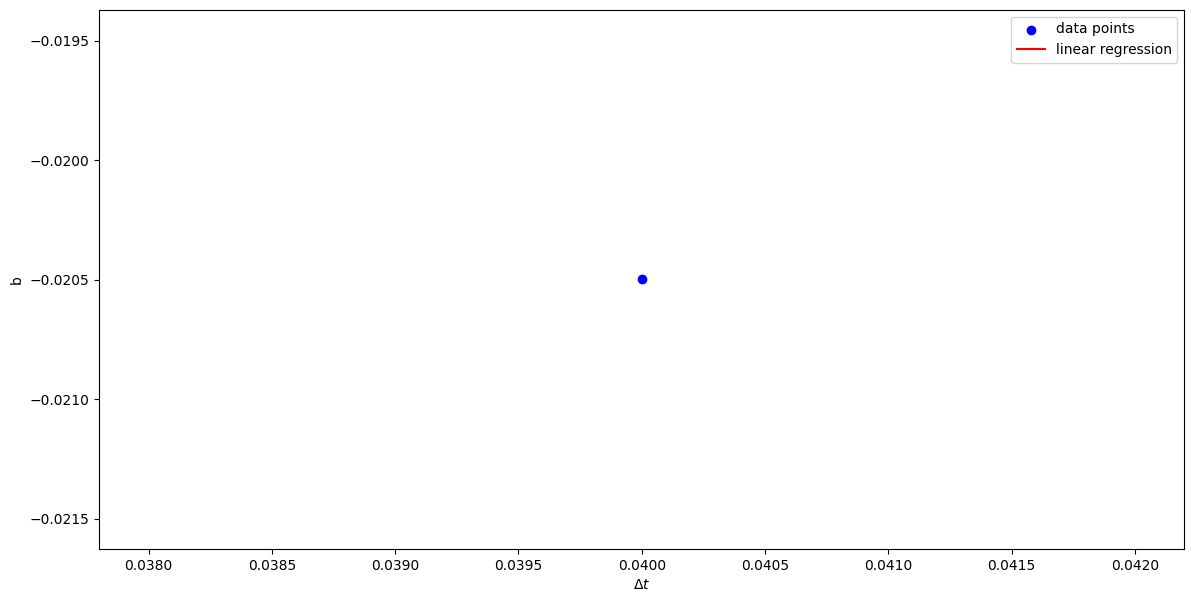

nan
0.0


In [11]:
from sklearn.linear_model import LinearRegression

# Data
x = np.array(list(b_inf.keys()))
y = np.array(list(b_inf.values()))
# Reshaping the data
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

# Linear regression
model = LinearRegression()
model.fit(x, y)

# Predictions
y_pred = model.predict(x)

# Metrics
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

# Plotting
plt.scatter(x, y, color="blue")
plt.plot(x, y_pred, color="red")
plt.legend(["data points", "linear regression"])
plt.xlabel(r"$\Delta t$")
plt.ylabel("b")
plt.show()

print(r2)
print(mse)

In [12]:
b = {
    0.09: -0.04149326001426795,
    0.08: -0.03619156685297887,
    0.07: -0.031200743054889162,
    0.06: -0.026949872411631656,
    0.05: -0.02233061936313961,
    0.04: -0.01775518475504853,
    0.03: -0.013427066164592378,
    0.02: -0.008894820875587083,
    0.01: -0.004312690532229825,
}